# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs
## Part : Monotone numerical schemes
## Chapter : The Monge-Ampere equation

This notebook presents a series of methods for numerically solving the Monge-Ampere equation
$$
    f(x) - \det(\nabla^2 u(x)) = 0,
$$
among convex functions, with Dirichlet boundary conditions. 
The function $f$ is assumed to be strictly positive.
For that purpose, we rely on the monotone and consistent MA-LBR numerical scheme (Monge-Ampere using Lattice Basis Reduction), and some variants.

**References.**

The MA-LBR scheme was first introduced in:
* Benamou, J.-D., Collino, F., & Mirebeau, J.-M. (2016). Monotone and Consistent discretization of the Monge-Ampere operator. Mathematics of Computation, 85(302), 2743–2775.

**Reformulation as an extremal operator.**
The starting point of these methods is to observe that, for a positive definite $d \times d$ matrix $M$
$$
    d (\det M)^\frac 1 d = \inf_{\det D = 1} \mathrm{Tr}(D M),
$$
where, implicitly, the optimization variable $D$ is also assumed to be a symmetric positive definite matrix.

If $M = \nabla^2 u$ is a hessian matrix, then the l.h.s. is (a multiple of a power of) the Monge-Ampere operator, while the r.h.s. is an infimum of second order linear operators, which can be discretized using monotone finite differences.

**Discretization strategy**
The chosen finite difference scheme for the linear operator is described in 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)
Since 


[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Naive non-monotone discretization (purposedly fails)](#1.-Naive-non-monotone-discretization-(purposedly-fails))
  * [2. The MA-LBR scheme](#2.-The-MA-LBR-scheme)
    * [2.1 First implementation](#2.1-First-implementation)
    * [2.2 Optimized implementation](#2.2-Optimized-implementation)
  * [3. Uniformly elliptic scheme](#3.-Uniformly-elliptic-scheme)
    * [3.1 First implementation](#3.1-First-implementation)
    * [3.2 Optimized implementation](#3.2-Optimized-implementation)
    * [3.3 Rotated domains](#3.3-Rotated-domains)
    * [3.4 degenerate solutions](#3.4-degenerate-solutions)
  * [4. Validation](#4.-Validation)
    * [4.1 Comparison with a sampling based scheme](#4.1-Comparison-with-a-sampling-based-scheme)
    * [4.2 The monotone and consistent schemes have identical solutions](#4.2-The-monotone-and-consistent-schemes-have-identical-solutions)
    * [4.3 Comparison with automatic differentiation](#4.3-Comparison-with-automatic-differentiation)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('MongeAmpere','NonDiv'))

In [2]:
from agd import Selling
from agd import Domain
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = "Figures/MongeAmpere"

In [3]:
import numpy as np
from matplotlib import pyplot as plt

Some utility functions

In [4]:
newton_root = ad.Optimization.newton_root
stop    = ad.Optimization.stop_default
damping = ad.Optimization.damping_default 
norm = ad.Optimization.norm

### 0.1 Additional configuration

Choose between small and large problem instances using the following. (Large instances require slightly longer CPU time.)

In [5]:
large_instances = False

## 1. Naive non-monotone discretization (purposedly fails)

We present a naive, non-monotone discretization of the addressed problem. This scheme can be used to check that a numerical solution (produced by other means) is correct, or to construct synthetic examples. However, using it to solve the PDE is usually bound to fail. 

The naive scheme is based on a reconstruction of the Hessian matrix of the form
$$
    \begin{pmatrix}
        D^h_{00} u(x) & D^h_{01} u(x)\\
        D^h_{01} u(x) & D^h_{11} u(x)
    \end{pmatrix},
$$
where $D_{00}$, $D_{01}$ and $D_{11}$ are finite-difference operators. Namely
$$
    D^h_{00} u(x) := \frac{u(x_0+h,x_1)-2 u(x_0,x_1) + u(x_0-h,x_1)}{h^2},
$$
likewise for $D^h_{11} u(x)$, and finally
$$
    D^h_{01} u(x) := \frac{u(x_0+h,x_1+h)-u(x_0-h,x_1+h)-u(x_0+h,x_1-h)+h(x_0-h,x_1-h)}{4 h^2}.
$$

In [6]:
def SchemeNonMonotone(u,f,bc):
    # Compute the hessian matrix of u
    uxx = bc.Diff2(u,(1,0))
    uyy = bc.Diff2(u,(0,1))
    uxy = 0.25*(bc.Diff2(u,(1,1)) - bc.Diff2(u,(1,-1)))
    
    # Numerical scheme
    det = uxx*uyy-uxy**2
    residue = f - det
    
    # Boundary conditions
    return np.where(bc.interior,residue,u-bc.grid_values)

We next choose some problem parameters

In [7]:
# Create the domain
n = 100 if large_instances else 60
aX0 = np.linspace(-1,1,n); aX1=aX0;
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

# Set the boundary conditions 
gridscale = aX0[1]-aX0[0]
bc_square = Domain.Dirichlet(Domain.Box([[-1,1],[-1,1]]),0.,X)
bc_convex = Domain.Dirichlet(Domain.Union(Domain.Ball(),Domain.Box()), 0., X)
bc_concave = Domain.Dirichlet(Domain.Complement(Domain.Ball(),Domain.Box()), 0., X)

# Choose the PDE parameters
f=1.

In [8]:
#bc_mock_grid_values = np.zeros(bc.shape); bc_mock_grid_values[1:-1,1:-1]=np.nan
#bc_mock = Domain.MockDirichlet(bc_mock_grid_values,gridscale,padding=np.inf)

The following quadratic function, often shifted by a constant value, will be used as a guess for the numerical methods.

In [9]:
quadratic = X[0]**2+X[1]**2

The naive and non-monotone discretization scheme is consistent, but lacks any other sort of theoretical guarantees. 

**In general, attempts to solve numerically the non-monotone scheme will fail. This is expected behavior**

The non-monotone scheme may nevertheless work for some specific gentle problem instances (with a smooth solution), a careful initialization, and a bit of luck. This is the case below.

<!---This is the case below, where we solve the same problem as above, but with a different handling of the boundary conditions: they are imposed implicitly by the padding values used in the finite differences.--->

Iteration: 1  Residue norm: 435.4293797115683
Iteration: 2  Residue norm: 108.59156527948129
Iteration: 3  Residue norm: 26.886132710785162
Iteration: 4  Residue norm: 6.472478000845846
Iteration: 5  Residue norm: 1.3980027897138632


Iteration: 6  Residue norm: 0.2036558796885759
Iteration: 8  Residue norm: 1.65223864314612e-05
Iteration: 9  Residue norm: 5.67510483051592e-11
Target residue reached. Terminating.


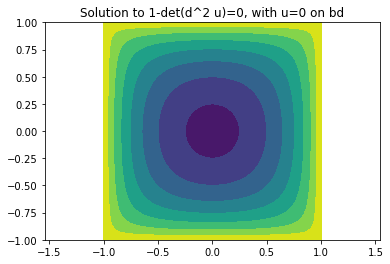

In [10]:
params = (f,bc_square)
solution_non_monotone = newton_root(SchemeNonMonotone,quadratic-2,params) 

plt.axis('equal'); plt.title("Solution to 1-det(d^2 u)=0, with u=0 on bd")
plt.contourf(*X,solution_non_monotone);

However, the non-monotone scheme fails even on a simple convex domain.

In [11]:
params = (f,bc_convex)
newton_root(SchemeNonMonotone,quadratic-2,params,
            stop = ad.Optimization.stop_default(raise_on_abort=False));

Iteration: 1  Residue norm: 171556391.26643014
Iteration: 2  Residue norm: 42889034.526972845
Iteration: 3  Residue norm: 10722228.865505394
Iteration: 4  Residue norm: 2680469.1542438697


Iteration: 5  Residue norm: 670099.4011284033
Iteration: 6  Residue norm: 6027061.056008674
Iteration: 8  Residue norm: 376495.4780648277


Iteration: 10  Residue norm: 148826.56910506307
Iteration: 12  Residue norm: 205675.54615336456


Iteration: 14  Residue norm: 1027339.918638973
Iteration: 16  Residue norm: 243314.47336558098


Iteration: 20  Residue norm: 80457295.36024685


Iteration: 24  Residue norm: 314281.00929225254


Iteration: 28  Residue norm: 28381.956237543174


Iteration: 32  Residue norm: 41627.83081261984
Iteration: 36  Residue norm: 9911.36905450509


Iteration: 40  Residue norm: 55428.35685439054


Iteration: 44  Residue norm: 291339.3659224649


Iteration: 48  Residue norm: 86523.2391382083
Iteration: 50  Residue norm: 16960.106673118422
Max iterations exceeded. Aborting.


## 2. The MA-LBR scheme

The MA-LBR scheme is a monotone and consistent discretization of the Monge-Ampere operator. It takes the form:
$$
    \Lambda u(x) := \inf_{(e_0,e_1,e_2) \in S} H( \Delta_{e_0}^h u(x), \Delta_{e_1}^h u(x), \Delta_{e_2}^h u(x)).
$$
We denoted by $S$ a family of superbases of $Z^2$, which is a parameter to the scheme that must be chosen, see below. 
Superbases are triplets $(e_0,e_1,e_2)$ of vectors $e_0,e_1,e_2 \in Z^2$ with integer coordinates.

We denoted second order finite differences, in a direction $e\in Z^2$ by 
$$
    \Delta_e^h u(x) := \frac{u(x+h e) -2 u(x) +u(x+he)} {h^2}.
$$
The scheme also features a three argument function $H$, defined as follows: $H(a,b,c) := H_0(a_+,b_+,c_+)$, where 
$$
    H_0(a,b,c) :=
    \begin{cases}
        a b \quad \text{ if }\ a+b < c, \text{ and likewise permuting } a,b,c\\
        \frac 1 2 (a b+b c+c a) - \frac 1 4 (a^2+b^2+c^2)\quad \text{ otherwise}.
    \end{cases}
$$


**Convexity of the solution, and ellipticity of the PDE and numerical scheme.**

The Monge-Ampere equation imposes, as a constraint, that the solution $u$ be convex. The ellipticity of the Monge-Ampere operator degenerates as $\det(\nabla^2 u) \to 0$, which means that $u$ looses convexity.

A similar issue arises with the MA-LBR scheme. It is strictly elliptic only as long as 
$$
    \Lambda u(x) > 0,
$$
which is a discrete counterpart of convexity. 

**Damping of the Newton method.**
We need to guarantee that, along the iterations, the numerical scheme ellipticity is preserved. 
A first requirement for this is to choose a strictly convex initialization, for instance the quadratic function $u(x) = \|x\|^2/2$.

For this reason, we also resort to a damped Newton method. The default behavior is to define
$$
    u_{n+1} = u_n + 2^{-k_n} d_n,
$$
where $d_n$ is the Newton descent direction, and $k_n$ is the least integer such that 
$$
    \Lambda u_{n+1}(x) \geq f(x)/2,
$$
at all discretization points $x$.
(Recall that the r.h.s $f$ is assumed to be strictly positive.)

We assume, for simplicity, that this condition holds at initialization. Otherwise a threshold lower than $f/2$ could be used.

*Note that a different scheme, presented in the next section of this notebook, is uniformly elliptic (independently of the unknown $u$), and thus does not require the precautions presented in the latter paragraph.*

### 2.1 First implementation

In [12]:
def MALBR_H(d2u):
    a,b,c = np.sort(np.maximum(0.,d2u), axis=0)

    # General formula, handling infinite values separately
    A,B,C = (np.where(e==np.inf,0.,e) for e in (a,b,c))
    result = 0.5*(A*B+B*C+C*A)-0.25*(A**2+B**2+C**2)
    
    pos_inf = np.logical_or.reduce(d2u==np.inf)    
    result[pos_inf]=np.inf
    
    pos_ineq = a+b<c
    result[pos_ineq] = (A*B)[pos_ineq]
        
    return result
    
def SchemeMALBR(u,SB,f,bc):
    # Compute the finite differences along the superbase directions
    d2u = bc.Diff2(u,SB)
    d2u[...,bc.not_interior] = 0. # Replace NaNs with arbitrary values to silence warnings
    
    # Numerical scheme
    residue = f-MALBR_H(d2u).min(axis=0)
    
    # Boundary conditions
    return np.where(bc.interior,residue,u-bc.grid_values)

We next implement the test used to select the damping parameter, as announced. 

In [13]:
def InvalidMALBR(u,SB,f,bc):
    residue = SchemeMALBR(u,SB,f,bc)
    return np.any(residue[bc.interior]>=f/2)

We next choose a family of superbases. The scheme is (second order) consistent while the condition number of the hessian of $u$ remains below the given bound. Beyond that, a consistency defect is introduced.

In [14]:
SB0 = Selling.SuperbasesForConditioning(5)
SB1 = Selling.SuperbasesForConditioning(15)
SB2 = Selling.SuperbasesForConditioning(30)

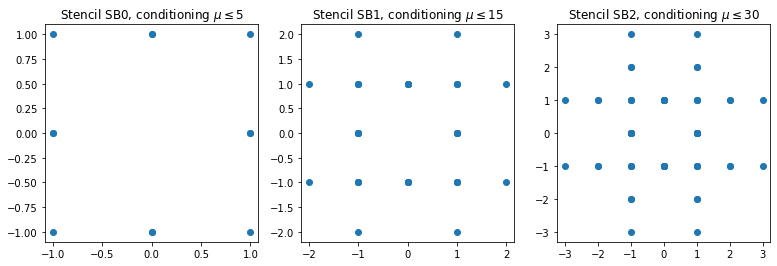

In [15]:
#Stencil of the MA-LBR scheme, for bounds (5,15,30) on conditioning'
def stencil(SB): return np.stack((SB,-SB),axis=2)[:,:]
fig = plt.figure(figsize=[13,4]);
plt.subplot(1,3,1);plt.scatter(*stencil(SB0)); plt.title(r"Stencil SB0, conditioning $\mu\leq 5$"); plt.axis('equal');
plt.subplot(1,3,2);plt.scatter(*stencil(SB1)); plt.title(r"Stencil SB1, conditioning $\mu\leq 15$"); plt.axis('equal');
plt.subplot(1,3,3);plt.scatter(*stencil(SB2)); plt.title(r"Stencil SB2, conditioning $\mu\leq 30$"); plt.axis('equal');
savefig(fig,'Stencils.pdf'); savefig(fig,'Stencils.png')

The initial guess is chosen to be in the ellipticity domain of the operator.

In [16]:
InvalidMALBR(quadratic-2.,SB0,f,bc_convex)

False

In [17]:
%%time
# This damping rule cuts the step size in half until the MALBR validity criterion is met
dampingMALBR = damping(criterion=InvalidMALBR)

params = (SB0,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR,quadratic-2.,params,damping=dampingMALBR)

Iteration: 1  Residue norm: 135390475.60848612
Iteration: 2  Residue norm: 103658332.13981329
Iteration: 3  Residue norm: 79363409.7256976


Iteration: 4  Residue norm: 44641914.43915084
Iteration: 5  Residue norm: 25111072.884717986
Iteration: 6  Residue norm: 6277751.34376764


Iteration: 8  Residue norm: 882797.0883439376
Iteration: 10  Residue norm: 279320.38525207544


Iteration: 12  Residue norm: 120292.74624860242
Iteration: 14  Residue norm: 70513.28981965923


Iteration: 16  Residue norm: 22310.598912788897


Iteration: 20  Residue norm: 2233.032155913912


Iteration: 24  Residue norm: 18.934895897691806


Iteration: 28  Residue norm: 0.0006070346046953556
Iteration: 30  Residue norm: 4.141131881851834e-13
Target residue reached. Terminating.
CPU times: user 1.91 s, sys: 332 ms, total: 2.24 s
Wall time: 2.24 s


The last Newton steps, close to the solution, equal one. In contrast, a stong damping is applied in some of the first. 

In [18]:
np.array(dampingMALBR.steps)

array([1.  , 0.25, 0.25, 0.5 , 0.5 , 1.  , 1.  , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.25, 0.25, 0.25, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

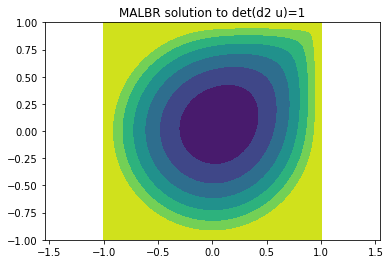

In [19]:
plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

The method also works for the square domain.

Iteration: 1  Residue norm: 435.22155528380245
Iteration: 2  Residue norm: 382.51427572985995
Iteration: 3  Residue norm: 292.8439861549559


Iteration: 4  Residue norm: 224.1904431127332
Iteration: 5  Residue norm: 126.03463821248806
Iteration: 6  Residue norm: 70.82174271083204


Iteration: 8  Residue norm: 4.048260275312941
Iteration: 10  Residue norm: 0.07924390414734717


Iteration: 12  Residue norm: 5.089807757485687e-07
Iteration: 13  Residue norm: 5.52891066263328e-13
Target residue reached. Terminating.
CPU times: user 737 ms, sys: 147 ms, total: 884 ms
Wall time: 880 ms


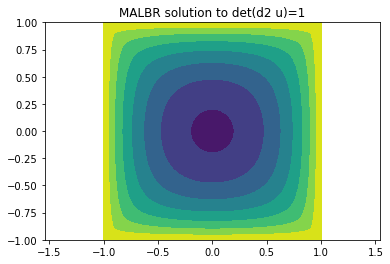

In [20]:
%%time
params = (SB0,f,bc_square)
solution_MALBR = newton_root(SchemeMALBR,quadratic-2.,params,damping=dampingMALBR)

plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

And with the non-convex domain.

Iteration: 1  Residue norm: 135390478.22601065
Iteration: 2  Residue norm: 76157142.58943662
Iteration: 3  Residue norm: 42838390.806212835


Iteration: 4  Residue norm: 24096592.50996785
Iteration: 5  Residue norm: 6024137.8032421805
Iteration: 6  Residue norm: 1506023.3985378228


Iteration: 8  Residue norm: 476511.5049978599
Iteration: 10  Residue norm: 150768.86559313658


Iteration: 12  Residue norm: 88377.79078491233
Iteration: 14  Residue norm: 51805.32469636485


Iteration: 16  Residue norm: 16391.253476792608


Iteration: 20  Residue norm: 143.4693035341923


Iteration: 24  Residue norm: 0.2405407739812797
Iteration: 27  Residue norm: 9.706679904297744e-11
Target residue reached. Terminating.
CPU times: user 1.58 s, sys: 242 ms, total: 1.82 s
Wall time: 1.81 s


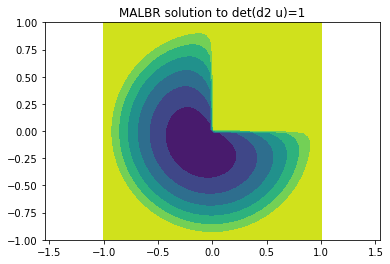

In [21]:
%%time
params = (SB0,f,bc_concave)
solution_MALBR = newton_root(SchemeMALBR,quadratic-2.,params,damping=dampingMALBR)

plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

### 2.2 Optimized implementation

In the course of the Newton method, the AD-LBR scheme is evaluated on sparse AD variables. In this regard, two features of the scheme yield optimization opportunities:
* *Minimization over the superbases.* Using the envelope theorem, we find the minimizer using ordinary arrays without AD information, and then provide this oracle information in a second pass involving AD information.
* *Complex non-linear function $H$.* We can take advantage of dense and sparse AD composition, to efficiently evaluate $H$.

**Important: other optimization opportunities.**
Our main intent in this subsection is to illustrate advanced AD techniques. There may be other optimization opportunities.

In [22]:
def SchemeMALBR_OptInner(u,SB,bc,oracle=None):
    # If the active superbases are known, then take only these
    if not(oracle is None):
        SB = np.take_along_axis(SB,np.broadcast_to(oracle,SB.shape[:2]+(1,)+oracle.shape),axis=2)
                
    d2u = bc.Diff2(u,SB)
    d2u[...,bc.not_interior] = 0. # Placeholder value to silent NaN warnings
    # Evaluate the complex non-linear function using dense - sparse composition
    result = ad.apply(MALBR_H,d2u,shape_bound=u.shape)
    
    return ad.min_argmin(result,axis=0)

def SchemeMALBR_Opt(u,SB,f,bc):
    
    # Evaluate using the envelope theorem
    result,_ = ad.apply(SchemeMALBR_OptInner, u,bc.as_field(SB),bc, envelope=True)
        
    # Boundary conditions
    return np.where(bc.interior, f - result, u-bc.grid_values)

We can afford more superbases, taking `SB2` instead of `SB0`, thanks to the optimizations. Replace `SchemeMALBR_Opt` with `SchemeMALBR` to see the computation time difference.

In [23]:
%%time
params = (SB2,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR_Opt,quadratic-2.,params,damping=dampingMALBR) 

Iteration: 1  Residue norm: 39496867.67646196
Iteration: 2  Residue norm: 30239789.29882167


Iteration: 3  Residue norm: 23152338.66587315
Iteration: 4  Residue norm: 13023190.435089173


Iteration: 5  Residue norm: 7325544.554367517
Iteration: 6  Residue norm: 4120618.7450495884


Iteration: 8  Residue norm: 257538.0910574192


Iteration: 10  Residue norm: 81482.62200696116


Iteration: 12  Residue norm: 35089.21739988965


Iteration: 14  Residue norm: 15108.931465891968


Iteration: 16  Residue norm: 6504.43112735921


Iteration: 20  Residue norm: 3143.879377365982


Iteration: 24  Residue norm: 487.4725737621711


Iteration: 28  Residue norm: 0.5871581304548648


Iteration: 31  Residue norm: 4.06244771156139e-09
Target residue reached. Terminating.
CPU times: user 3.92 s, sys: 744 ms, total: 4.66 s
Wall time: 4.7 s


If we use the same set of superbases, then the optimized and non-optimized versions yield an identical result, up to machine precision, iteration after iteration.

In [24]:
%%time
params = (SB0,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR_Opt,quadratic-2.,params,damping=dampingMALBR) 

Iteration: 1  Residue norm: 135390475.6084862
Iteration: 2  Residue norm: 103658332.13981333


Iteration: 3  Residue norm: 79363409.72569765


Iteration: 4  Residue norm: 44641914.439150855
Iteration: 5  Residue norm: 25111072.884718
Iteration: 6  Residue norm: 6277751.343767642


Iteration: 8  Residue norm: 882797.088343938
Iteration: 10  Residue norm: 279320.3852520756


Iteration: 12  Residue norm: 120292.74624860245
Iteration: 14  Residue norm: 70513.28981965921


Iteration: 16  Residue norm: 22310.598912788897


Iteration: 20  Residue norm: 2233.032155913913


Iteration: 24  Residue norm: 18.93489589769176


Iteration: 28  Residue norm: 0.0006070346046953556
Iteration: 30  Residue norm: 4.141131881851834e-13
Target residue reached. Terminating.
CPU times: user 1.8 s, sys: 122 ms, total: 1.92 s
Wall time: 1.92 s


## 3. Uniformly elliptic scheme

We present a numerical scheme robust enough that the Newton method converges *without need for damping*, even in the non-convex domains. For that purpose, we use the following classical reformulation of the Monge-Ampere PDE.
$$
    0 = \max_D \alpha(x)\det(D)^\frac 1 d - \mathrm{Tr} (D \nabla^2 u(x))
$$
subject to the constraints
$$
    D \succeq 0, \qquad \mathrm{Tr} (D) = 1,
$$
and where we denoted
$$
    \alpha(x) := d f(x)^{\frac 1 d}.
$$

### Reformulation as a quadratic optimization problem

We constrain the above optimization problem to matrices $D$ which can be decomposed over a superbase $(e_0,e_1,e_2)$ of $Z^2$ in the form
$$
    D = \sum_i v_i e_i e_i^T,
$$
where $v_i \geq 0$, $0 \leq i \leq 2$.
We can compute the trace of $D$ 
$$
    \mathrm{Tr}(D) = \sum_i v_i \|e_i\|^2,
$$
and its determinant
$$
    \det(D) = v_0 v_1 + v_1 v_2 + v_2 v_0 = <v,Q v>
$$
where 
$$
    Q = \frac 1 2 \begin{pmatrix} 0 & 1 & 1\\ 1 & 0 & 1\\ 1 & 1 & 0 \end{pmatrix}
$$
In addition, we have the finite differences approximation
$$
    \mathrm{Tr}(D \nabla^2 u(x)) \approx \sum_i v_i \frac{ u(x+h e_i)-2 u(x)+u(x-he_i)} {h^2}
$$


### Solving a low dimensional constrained optimization problem
We need to solve the concave maximization problem 
$$
    \max_v \alpha\sqrt{<v,Q v>} + <l,v>
$$
subject to the constraints
$$
    v \succeq 0, \qquad <m,v>=1.
$$

**Distinction on $\alpha$**
The scalar $\alpha$ is by assumption non-negative.
If $\alpha=0$, then the solution to the above optimization problem is 
$$
    \max_{1 \leq i \leq d} \frac{l_i}{m_i}.
$$
On the other hand, if $\alpha>0$, then we may assume $\alpha=1$, up to including it in $Q$.

**Optimality relation**
Assuming that the positivity constraints are inactive at the maximizer, we obtain the optimality relation
$$
    \frac {Q v}{\sqrt{<v,Q v>}} + l = \mu m,
$$
for some Lagrange multiplier $\mu \in R$.

**Solving the problem.**
A quadratic equation is obeyed by this multiplier
$$
    <(\mu m -l), Q^{-1} (\mu m -l)> = 1.
$$
(Which root is to be selected ?)
The minimizer can be obtained by 
$$
    \frac{v}{\sqrt{<v,Q v >}} = Q^{-1} (\mu m -l)
$$

### 3.1 First implementation

In [25]:
def ConstrainedMaximize(Q,l,m):
    dim = l.shape[0]
    if dim==1:
        return (l[0]+np.sqrt(Q[0,0]))/m[0]
    
    # Discard infinite values, handled afterwards
    pos_bad = l.min(axis=0)==-np.inf
    L = l.copy(); L[:,pos_bad]=0
    
    # Solve the quadratic equation
    A = lp.inverse(Q)    
    lAl = lp.dot_VAV(L,A,L)
    lAm = lp.dot_VAV(L,A,m)
    mAm = lp.dot_VAV(m,A,m)
    
    delta = lAm**2 - (lAl-1.)*mAm
    pos_bad = np.logical_or(pos_bad,delta<=0)
    delta[pos_bad] = 1.
    
    mu = (lAm + np.sqrt(delta))/mAm
    
    # Check the positivity
#    v = dot_AV(A,mu*m-L)
    rm_ad = np.array
    v = lp.dot_AV(rm_ad(A),rm_ad(mu)*rm_ad(m)-rm_ad(L))
    pos_bad = np.logical_or(pos_bad,np.any(v<0,axis=0))
    
    result = mu
    result[pos_bad] = -np.inf
    
    # Solve the lower dimensional sub-problems
    # We could restrict to the bad positions, and avoid repeating computations
    for i in range(dim):             
        axes = np.full((dim),True); axes[i]=False
        res = ConstrainedMaximize(Q[axes][:,axes],l[axes],m[axes])
        result = np.maximum(result,res)
    return result

In [26]:
def SchemeUniform(u,SB,f,bc):
    # Compute the finite differences along the superbase directions
    d2u = bc.Diff2(u,SB) 
    d2u[...,bc.not_interior] = 0. # Placeholder value to silent NaN warnings
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    l = -d2u
    m = lp.dot_VV(SB,SB)
    
    # Evaluate the numerical scheme
    m = bc.as_field(m)
    from agd.FiniteDifferences import as_field
    Q = as_field(Q,m.shape[1:])
    
    dim = 2
    alpha = dim * f**(1/dim)
    mask= (alpha==0)

    Q = Q* np.where(mask,1.,alpha**2)
    residue = ConstrainedMaximize(Q,l,m).max(axis=0)
    residue[mask] = np.max(l/m,axis=0).max(axis=0)[mask]
    
    # Boundary conditions
    return np.where(bc.interior,residue,u-bc.grid_values)

The monotone scheme is able to approach discontinuous vicosity solutions, defined on non-convex domains.

In [27]:
%%time
relax = ad.Sparse.identity(bc_concave.shape)
stop = ad.Optimization.stop_default

params = (SB0,f,bc_concave)
solution_Uniform = newton_root(SchemeUniform,quadratic-2.,params)

fig = plt.figure(figsize=(5,4)); plt.axis('equal')
plt.title(r"$\det(d^2 u)=1$, $u=0$ on $\partial \Omega$, concave domain"); 
plt.contourf(*X,solution_Uniform);  plt.colorbar();

savefig(fig,'UniformScheme_ConcaveDomain_SB0.png')

Iteration: 1  Residue norm: 41.75305780478243


Iteration: 2  Residue norm: 1.7029357624554848


Iteration: 3  Residue norm: 0.2780977824996734


Iteration: 4  Residue norm: 0.013033072888576913


Iteration: 5  Residue norm: 8.622886755604853e-05


Iteration: 6  Residue norm: 1.371700841801271e-08


It also still works on simpler cases, such as the square and convex domain.

Iteration: 1  Residue norm: 31.096144220994248
Iteration: 2  Residue norm: 1.5991606276101096
Iteration: 3  Residue norm: 0.49335073319999506
Iteration: 4  Residue norm: 0.18289293932936646
Iteration: 5  Residue norm: 0.06866940060658422
Iteration: 6  Residue norm: 0.01787979256842931
Iteration: 8  Residue norm: 1.2365056338836666e-05
Iteration: 9  Residue norm: 7.765015297422906e-10
Target residue reached. Terminating.
CPU times: user 2min 48s, sys: 4.71 s, total: 2min 53s
Wall time: 1min 52s


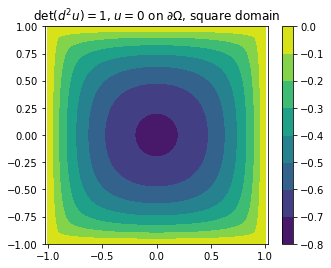

In [38]:
%%time
params = (SB0,f,bc_square)
solution_Uniform = newton_root(SchemeUniform,quadratic-2.,params) 

fig = plt.figure(figsize=(5,4)); plt.axis('equal')
plt.title(r"$\det(d^2 u)=1$, $u=0$ on $\partial \Omega$, square domain"); 
plt.contourf(*X,solution_Uniform); plt.colorbar();

savefig(fig,'UniformScheme_SquareDomain_SB0.png')

In [ ]:
%%time
params = (SB0,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform,quadratic-2.,params)

fig = plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title(r"det(d^2 u)=1, uniformly elliptic scheme")
plt.contourf(*X,solution_Uniform); #plt.colorbar();

savefig(fig,'UniformScheme_ConvexDomain_SB0.png')

### 3.2 Optimized implementation

We optimize the uniformly elliptic scheme using the same ingredients as for the MA-LBR scheme: the envelope theorem, and dense-sparse AD composition.

In [39]:
def SchemeUniform_OptInner(u,SB,f,bc,oracle=None):
    # Use the oracle, if available, to select the active superbases only
    if not(oracle is None):
        SB = np.take_along_axis(SB,np.broadcast_to(oracle,SB.shape[:2]+(1,)+oracle.shape),axis=2)

    d2u = bc.Diff2(u,SB) 
    d2u[...,bc.not_interior] = 0. # Placeholder value to silent NaN warnings
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    dim = 2
    l = -d2u
    m = lp.dot_VV(SB,SB)
    
    m = bc.as_field(m)
    from agd.FiniteDifferences import as_field
    Q = as_field(Q,m.shape[1:])
    
    dim = 2
    alpha = dim * f**(1/dim)
    mask= (alpha==0)

    Q = Q* np.where(mask,1.,alpha**2)
    # Evaluate the non-linear functional using dense-sparse composition
    residue = ad.apply(ConstrainedMaximize,Q,l,m,shape_bound=u.shape).copy()
    residue[:,mask] = np.max(l/m,axis=0)[:,mask]
    
    return ad.max_argmax(residue,axis=0)

def SchemeUniform_Opt(u,SB,f,bc):
    
    # Evaluate the maximum over the superbases using the envelope theorem
    residue,_ = ad.apply(SchemeUniform_OptInner, u,bc.as_field(SB),f,bc, envelope=True)
    
    return np.where(bc.interior,residue,u-bc.grid_values)

The computation time is significantly reduced with these optimizations, and we can afford to take more superbases: `SB2` instead of `SB0`.

In [40]:
%%time
params = (SB2,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform_Opt,quadratic-2.,params) 

Iteration: 1  Residue norm: 47.70893460891318
Iteration: 2  Residue norm: 6.174106694434803
Iteration: 3  Residue norm: 2.6577637825055587
Iteration: 4  Residue norm: 0.35381277003556266
Iteration: 5  Residue norm: 0.06976213055799763
Iteration: 6  Residue norm: 0.010958974255689036
Iteration: 8  Residue norm: 5.874809261285918e-08
Iteration: 9  Residue norm: 2.1271873151818e-13
Target residue reached. Terminating.
CPU times: user 2min 29s, sys: 5.15 s, total: 2min 34s
Wall time: 55.3 s


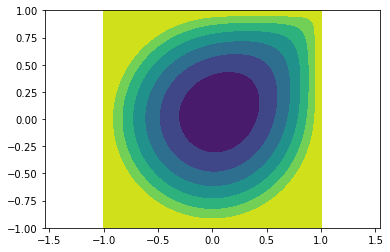

In [41]:
plt.contourf(*X,solution_Uniform); plt.axis('equal');

In [42]:
%%time
params = (SB0,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform_Opt,quadratic-2.,params) 

Iteration: 1  Residue norm: 46.82454080471667
Iteration: 2  Residue norm: 1.4685637681149122
Iteration: 3  Residue norm: 0.47021035626734303
Iteration: 4  Residue norm: 0.15858952521536762
Iteration: 5  Residue norm: 0.04842040273523418
Iteration: 6  Residue norm: 0.00563655495520532
Iteration: 8  Residue norm: 1.3251621799881264e-08
Iteration: 9  Residue norm: 2.1405099914773018e-13
Target residue reached. Terminating.
CPU times: user 1min 51s, sys: 5.87 s, total: 1min 57s
Wall time: 52.3 s


### 3.3 Rotated domains

The domains considered in this notebook have some of their edges aligned with the coordinate axes, which may give an unfair advantage given to grid based methods. We show in the experiments below that our implementations are equally efficient on rotated domains.

In [ ]:
%%time
bc_convex_rotated = Domain.Dirichlet(Domain.AffineTransform(bc_convex.domain,0.75*lp.rotation(-np.pi/6)),0.,X)
params = (SB2,f,bc_convex_rotated)
solution = newton_root(SchemeUniform_Opt,quadratic-2.,params) 

fig=plt.figure(figsize=[4,4]); plt.axis('equal');
plt.title(r"$\det(d^2u)=1$, rotated convex domain")
plt.contourf(*X,solution); 

savefig(fig,"UniformScheme_RotatedConvexDomain_SB2.png")

In [ ]:
%%time
bc_concave_rotated = Domain.Dirichlet(Domain.AffineTransform(bc_concave.domain,lp.rotation(-np.pi/6)),0.,X)
params = (SB2,f,bc_concave_rotated)
solution = newton_root(SchemeUniform_Opt,quadratic-2.,params)

fig=plt.figure(figsize=[4,4]); plt.axis('equal');
plt.title(r"$\det(d^2u)=1$, rotated concave domain")
plt.contourf(*X,solution); 

savefig(fig,"UniformScheme_RotatedConcaveDomain_SB2.png")

In [ ]:
bc=bc_concave_rotated; grad = np.array(np.gradient(solution,bc.gridscale))
grad[:,np.logical_not(bc.domain.contains_ball(X,2.5*bc.gridscale))]=0.

fig = plt.figure(figsize=[5,4]);  plt.axis('equal')
plt.axis('equal'); plt.title(r"Norm of the solution gradient, rotated concave domain")
plt.pcolormesh(*X,norm(grad,ord=2,axis=0)); plt.colorbar();

Non-simply connected domains raise no difficulty either.

In [ ]:
outer = Domain.Union(Domain.Ball(),Domain.Box([[0,1],[-1,1]]))
inner = Domain.AffineTransform(outer,0.4*lp.rotation(np.pi/3))
domain_ring = Domain.Complement(outer,inner)

def bc_value_ring(x):
    """0 on inner boundary, 1 on outer boundary."""
    return outer.level(x)+inner.level(x) > 0

bc_ring = Domain.Dirichlet(domain_ring,bc_value_ring,X)

In [ ]:
solution = newton_root(SchemeUniform_Opt,quadratic-2.,(SB2,f,bc_ring))

fig=plt.figure(figsize=[4,4]); plt.axis('equal');
plt.title(r"$det(d^2u)=1$, non-smooth ring-shaped domain")
plt.contourf(*X,solution); 

### 3.4 degenerate solutions

The Monge-Ampere equation $\det(\nabla^2 u)=f$ assumes a non-negative right-hand-side $f\geq 0$.
When $f=0$, the Monge-Ampere equation degenerates to the convex envelope equation
$$
    \lambda_{\min}(\nabla^2 u) = 0.
$$
The uniformly elliptic scheme also degenerates to a simpler scheme when $f=0$, namely
$$
    \max_{e \in E} \frac{- \Delta^e_h u(x)}{\|e\|^2} = 0,
$$
where $E$ is a set of vectors with integer coordinates, defined as the union of all superbases involved in the scheme.

Due to lack of strong ellipticity of the convex envelope equation, there is no hope to achieve a consistent discretization with a finite stencil. A consistency defect is introduced, which depends on the size of the stencil.

We illustrate this behavior with a piecewise linear function. In this case, the accuracy of the solution depends almost exclusively on the stencil size, and is independent of the grid size. 

In [ ]:
def bc_abs_value(x):
    return np.abs(x[0]+x[1]/np.sqrt(10))

By design, non-differentiability set is a line of irrational slope. Indeed, the solution could otherwise be exactly recovered with a suitable stencil, e.g. in the case of $|x_0|$.

In [ ]:
bc_abs = Domain.Dirichlet(bc_convex.domain,bc_abs_value,X)

In [ ]:
solution_SB0 = newton_root(SchemeUniform_Opt,quadratic-2.,(SB0,0.,bc_abs)) 
solution_SB1 = newton_root(SchemeUniform_Opt,quadratic-2.,(SB1,0.,bc_abs)) 
solution_SB2 = newton_root(SchemeUniform_Opt,quadratic-2.,(SB2,0.,bc_abs)) 

As expected, the solution improves as the stencil size increases.

In [ ]:
fig=plt.figure(figsize=[13,4])
plt.subplot(1,3,1)
plt.title("8 points stencil (SB0)")
plt.contour(*X,solution_SB0,levels=30); plt.axis('equal')
plt.subplot(1,3,2)
plt.title("16 points stencil (SB1)")
plt.contour(*X,solution_SB1,levels=30); plt.axis('equal')
plt.subplot(1,3,3)
plt.title("24 points stencil (SB2)")
plt.contour(*X,solution_SB2,levels=30); plt.axis('equal')
savefig(fig,"UniformScheme_AbsoluteValue.png",dpi=100)

We can also solve the Monge-Ampere equation with a r.h.s. vanishing on part of the domain only. 
Here the rhs is $1$, except in the upper quadrant rotated by $\pi/6$ where it is $0$. The resulting solution has a degenerate hessian on part of the domain.

In [ ]:
bc_ball = Domain.Dirichlet(Domain.Ball(),0.,X)
def rhs(x):
    c,s = np.cos(np.pi/6),np.sin(np.pi/6)
    return 1-np.logical_and(c*x[0]-s*x[1]>=0,s*x[0]+c*x[1]>=0)
solution = newton_root(SchemeUniform_Opt,quadratic-2.,(SB2,rhs(X),bc_ball)) 

In [ ]:
fig=plt.figure(figsize=[4,4]); 
plt.title(r"$\det(d^2 u)=f$, with $f=0$ on an angular sector")
plt.contourf(*X,solution); plt.axis('equal');
savefig(fig,"UniformScheme_VanishingRHS_SB2.png")

In [ ]:
bc=bc_ball; grad = np.array(np.gradient(solution,bc.gridscale))
grad[:,np.logical_not(bc.domain.contains_ball(X,2.5*bc.gridscale))]=0.

fig = plt.figure(figsize=[5,4]);  plt.axis('equal')
plt.axis('equal'); plt.title(r"Norm of the solution gradient, vanishing r.h.s")
plt.pcolormesh(*X,norm(grad,ord=2,axis=0)); plt.colorbar();

## 4. Validation

When designing and implementing a numerical method, one must distinguish:
* *Mathematical correctness*. A proof on paper that the scheme solutions exist, are unique, and e.g. do converge toward the solution of a continuous problem of interest as the grid is refined.
* *Implementation correctness*. The fact that the code faithfully reflects the mathematical description. A.k.a the absence of bugs. 

This section deals with implementation correctness. Again, there are two options:
* Computer assisted proof of correctness. This approach is still mostly sci-fy at the moment, although I would love it in principle. See [F*](https://www.fstar-lang.org/) for such works.
* A series of tests showing that the implementation obeys some expected mathematical properties. 

We rely on the second approach, and for that purpose we compare the implemented schemes between themselves, and with variants.

In [ ]:
LInfNorm=ad.Optimization.norm_infinity

### 4.1 Comparison with a sampling based scheme

The scheme described above is based on a discretization of the PDE formulation
$$
    0 = \max_D \det(D)^\frac 1 d - \alpha(x) \mathrm{Tr} (D \nabla ^2 u(x))
$$
followed with an exact solution subject to the constraints
$$
    D \succeq 0, \qquad \mathrm{Tr} (D) = 1,
$$
and the additional constraint that some superbase $s \in SB$ is obtuse. Denote by $F_{SB}$ this scheme.

**Sampling based scheme**
For validation purposes, it can be interesting to consider a brute-force approach to the same optimization problem, based on a sampling of the parameter space. Namely
$$
    D(\mu,\theta) := R_\theta 
    \begin{pmatrix} \mu & 0 \\ 0 & 1-\mu \end{pmatrix}
    R_\theta^T
$$
where $\mu\in M_n \subset [0,1/2]$ and $\theta\in \Theta_n [0,\pi]$. Here $A_n$ and $\Theta_n$ are $n$-element regular sampling of their respective containing intervals. 

Let us denote by $F^n$ this second scheme, and by $F^n_{SB}$ the same similar scheme where one only keeps matrices $D(\mu,\theta)$ for which some superbase $s \in SB$ is obtuse.

**Convergence**
By construction, one should have as $n \to \infty$, for any discrete map $u$ and set of superbases $SB$
$$
    F_{SB}^n(u) = F_{SB}(u) + O(n^{-1}).
$$
Note that the test function $u$, and the set of superbases are here fixed.

**Similar work** A similar approach is implemented in the notebook [NonlinearMonotoneSecond2D](NonlinearMonotoneSecond2D.ipynb). In that case, the order of convergence is $O(n^{-2})$, instead of $O(n^{-1})$. The difference is related with the sampling of the boundary of the optimization domain.

In [ ]:
def SchemeSampling(u,mus,thetas,SB,f,bc):
    # Sampling is independent for mu and theta
    mus=np.expand_dims(mus,axis=0)
    thetas=np.expand_dims(thetas,axis=1)

    # Build the tensors
    e=np.array(((np.cos(thetas),np.sin(thetas)),(-np.sin(thetas),np.cos(thetas))) )
    D = mus*lp.outer_self(e[0])+(1.-mus)*lp.outer_self(e[1])
    
    # Select the tensors for which one of the superbases is obtuse
    # This step is only needed if one intends to reproduce the consistent schem
    if D is not None:
        nD = np.prod(D.shape[2:]); D=D.reshape((2,2,1,1,nD))
        nSB=SB.shape[2]; SB=SB.reshape((2,3,nSB,1))
        scals = lp.dot_VAV(SB,D,np.roll(SB,axis=1,shift=1))
        # Test if a given superbase is obtuse for a given tensor
        is_obtuse = scals.max(axis=0)<=0 
        # Test if a given tensor admits an obtuse superbase among the proposed ones
        is_admissible = is_obtuse.any(axis=0)
        D=D.squeeze(axis=(2,3))
        D=D[:,:,is_admissible]
    

    # Decompose the tensors
    coefs,offsets = Selling.Decomposition(D)
    coefs = bc.as_field(coefs)
    
    # Discretization
    d=2.
    alpha = 1./(d*f**(1./d))
    d2u = bc.Diff2(u,offsets)    
    detD = bc.as_field(lp.det(D))
    res = detD**(1./d)-alpha*(coefs*d2u).sum(axis=0)
    # Note : optimization opportunity using the envelope theorem
    residue = res.max(axis=0) 
    return np.where(bc.interior,residue,u-bc.grid_values)

In [ ]:
np.random.seed(42)
u = np.random.uniform(-1,1,bc_square.shape)
bc_mock = Domain.MockDirichlet(u.shape,1.,0.)
params = (SB0,f,bc_mock)

residue_consistent = SchemeUniform(u,*params)

def error(n): 
    mus=np.linspace(0,0.5,n,endpoint=False)+0.25/n
    thetas=np.linspace(0,np.pi,n,endpoint=False)
    residue_sampling = SchemeSampling(u,mus,thetas,*params)

    LInfNorm=ad.Optimization.norm_infinity
    residue_diff = residue_sampling-residue_consistent
    return LInfNorm(residue_sampling-residue_consistent)

In [ ]:
samples = [5,8,12,16,20,25,30,35,40] #,50,60,70,80,100]
errors = [error(n) for n in samples]

The sampling based scheme does converge toward the consistent scheme, with the expected convergence order $O(n^{-1})$.

In [ ]:
isamples=1./np.array(samples); plt.title("Convergence of the sampling based scheme toward the consistent scheme")
plt.loglog(isamples,errors, isamples,isamples);

### 4.2 The monotone and consistent schemes have identical solutions

The implementation of the MALBR scheme and of the Uniformly elliptic schemes are quite different. 
However, it can be shown that a solution to the first scheme is a solution to the second scheme, and conversely.

This is not a convergence result as a grid is refined. It is a result valid at any fixed scheme, up to machine precision due to rounding errors. Note also that the scheme residues are in general different if they are non-zero.

In [ ]:
params = (SB2,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform_Opt,quadratic-2.,params) 

In [ ]:
LInfNorm(SchemeMALBR_Opt(solution_Uniform,*params))

### 4.3 Comparison with automatic differentiation

We rely on automatic differentiation to compute the derivatives of an analytic function, and evaluate the PDE operator of interest. We then compute the numerical scheme residue on a synthetic problem with a known solution.

In [ ]:
def Hessian_ad(u,x):
    x_ad = ad.Dense2.identity(constant=x,shape_free=(2,))
    return u(x_ad).hessian()
def MongeAmpere_ad(u,x):
    return lp.det(Hessian_ad(u,x))

In [ ]:
def Residue_ad(u,SB,dom,X,scheme=SchemeMALBR):
    bc = Domain.Dirichlet(dom,u,X)
    rhs = MongeAmpere_ad(u,X)
    residue = scheme(u(X),SB,rhs,bc)
    residue[bc.not_interior]=0
    return residue

It is also interesting to know the condition number of the hessian of our analytic function, in order to wisely choose the set of superbases. The condition number is defined as the ratio of the largest and smallest eigenvalue.

In [ ]:
from agd.Metrics import Riemann
def HessianConditionNumber(u,x):
    return Riemann(Hessian_ad(u,x)).anisotropy()**2

In [ ]:
def test_quadratic(x): # Positive definite by non-isotropic quadratic function
    return x[0]**2+2*x[1]**2+2*1.3*x[0]*x[1] 
def test_polynomial(x):
    return (x[0]**2+x[1]**2)**2

Recall that `SB0` (resp. `SB1`, `SB2`) are guaranteed to yield a consistent discretization of the Monge-Ampere operator provided the hessian condition number is bounded by $5$ (resp. $15$, $30$).

In [ ]:
np.max(HessianConditionNumber(test_quadratic,X)),np.max(HessianConditionNumber(test_polynomial,X))

We know for sure that `SB2` is adequate for the quadratic polynomial - but it happens, by chance, that `SB1` also does the job, see below. Also, `SB0` (hence also `SB1` and `SB2`) will work for the polynomial test function.

In [ ]:
dom_convex = Domain.Union(Domain.Ball(),Domain.Box())
[norm(Residue_ad(test_quadratic,SB,dom_convex,X),ord=np.inf) for SB in (SB0,SB1,SB2)]

We next consider the impact of the grid scale on the residue norm.

In [ ]:
def X_(n):
    aX = np.linspace(-1,1,n)
    return np.array(np.meshgrid(aX,aX,indexing='ij'))

In the interior, the numerical scheme is second order accurate. 

In [ ]:
print("L^1 norm of MALBR residue at resolution 25,50,100")
[norm(Residue_ad(test_polynomial,SB0,dom_convex,X_(n)),ord=1,averaged=True) for n in (26,50,100)]

But the scheme is only first order accurate at the boundary.

In [ ]:
print("L^Infinity norm of MALBR residue at resolution 25,50,100")
[norm(Residue_ad(test_polynomial,SB0,dom_convex,X_(n)),ord=np.inf) for n in (26,50,100)]

In [ ]:
print("L^1 norm of uniformly elliptic scheme residue at resolution 25,50,100")
[norm(Residue_ad(test_polynomial,SB1,dom_convex,X_(n),scheme=SchemeUniform),ord=1,averaged=True) for n in (25,50,100)]

In [ ]:
print("L^Infinity norm of uniformly elliptic scheme residue at resolution 25,50,100")
[norm(Residue_ad(test_polynomial,SB0,dom_convex,X_(n),scheme=SchemeUniform),ord=np.inf) for n in (25,50,100)]